In [ ]:
# https://github.com/marcellusruben/medium-resources/blob/main/Text_Classification_BERT/bert_medium.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pickle5
!pip install toposort

     |████████████████████████████████| 256 kB 4.2 MB/s 


In [3]:
import pickle5 as pickle

In [4]:
data_dir = 'drive/MyDrive/stat940/dc2'
model_path = f'{data_dir}/model'

In [5]:
with open(f"{data_dir}/train.pickle", "rb") as f:
    total_dict = pickle.load(f)

with open(f"{data_dir}/test.pickle", "rb") as f:  
    test_dict = pickle.load(f)

for key, val in test_dict.items():
   test_dict[key] = val[0]

In [6]:
!pip install transformers==4.11.2 

     |████████████████████████████████| 2.9 MB 4.1 MB/s 
     |████████████████████████████████| 67 kB 6.3 MB/s 
     |████████████████████████████████| 3.3 MB 53.4 MB/s 
     |████████████████████████████████| 895 kB 67.7 MB/s 
     |████████████████████████████████| 596 kB 81.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [90]:
import pandas as pd
import torch
import numpy as np
from scipy import stats
import time
from transformers import BertTokenizerFast, BertModel
from toposort import toposort
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [9]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {DEVICE}')

device: cuda:0


In [10]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, data_dict):

        texts, labels = self.tokenize_dict(data_dict)

        self.texts = texts
        self.labels = labels
    
    def tokenize_dict(self, data_dict):
        texts = []
        labels = []
        t0 = time.time()
        for k, (sentences, positions) in data_dict.items():
            if (k+1) % 5000 == 0:
                print(f'{k} samples processed, split time:{time.time()-t0}')
                t0 = time.time()
            for i, s in enumerate(sentences):
                for j in range(i+1, len(sentences)):
                    labels.append(1 if positions[i] < positions[j] else 0)
                    texts.append(tokenizer(s+sentences[j], 
                                           padding='max_length', 
                                           max_length = 45, 
                                           truncation=True, 
                                           return_tensors="pt"))
        return texts, labels


    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


class Testset(torch.utils.data.Dataset):

    def __init__(self, data_dict):

        texts = self.tokenize_dict(data_dict)

        self.texts = texts
    
    def tokenize_dict(self, data_dict):
        texts = []
        t0 = time.time()
        for k, sentences in data_dict.items():
            if (k+1) % 5000 == 0:
                print(f'{k} samples processed, split time:{time.time()-t0}')
                t0 = time.time()
            edges = {}
            for i, s in enumerate(sentences):
                for j in range(i+1, len(sentences)):
                    edges[(i,j)] = (tokenizer(s+sentences[j], 
                                              padding='max_length', 
                                              max_length = 45, 
                                              truncation=True, 
                                              return_tensors="pt"))
            texts.append((k, edges))
        
        return texts


    def __len__(self):
        return len(self.texts)

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        key, batch_texts = self.get_batch_texts(idx)

        return key, batch_texts

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [12]:
def train(model, train_dataloader, val_dataloader, learning_rate, epochs):

    #train, val = Dataset(train_data), Dataset(val_data)

    #train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    #val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataloader): .3f} | Train Accuracy: {total_acc_train / len(train_dataloader): .3f} | Val Loss: {total_loss_val / len(valid_dataloader): .3f} | Val Accuracy: {total_acc_val / len(valid_dataloader): .3f}')
                  



In [120]:
def evaluate(model, test_dataloader):

    #test = Dataset(test_data)

    #test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    predictions = {}
    with torch.no_grad():

        for idx, edge_inputs in test_dataloader:

              edge_weights = {}

              for (i,j), test_input in edge_inputs.items():
                  mask = test_input['attention_mask'].to(device)
                  input_id = test_input['input_ids'].squeeze(1).to(device)

                  output = model(input_id, mask)
                  edge_weights[(i,j)] = (int(output.argmax(dim=1)), 
                                         float(torch.max(output)))

              predictions[idx] = edge_weights
                  #batch_pred = list() 
                  #predictions += batch_pred
    
    return predictions

In [14]:
cutoff = int(0.99*len(total_dict))
train_dict = {i: total_dict[i] for i in range(cutoff)}
valid_dict = {i: total_dict[i] for i in range(cutoff, len(total_dict))}


In [15]:
train_set = Dataset(train_dict)
valid_set = Dataset(valid_dict)

4999 samples processed, split time:6.801320791244507
9999 samples processed, split time:6.86014723777771
14999 samples processed, split time:6.941063642501831
19999 samples processed, split time:6.703740358352661
24999 samples processed, split time:6.352171897888184
29999 samples processed, split time:6.824751615524292
34999 samples processed, split time:6.887377738952637
39999 samples processed, split time:6.330465793609619
44999 samples processed, split time:6.317007780075073
49999 samples processed, split time:6.92615818977356
54999 samples processed, split time:6.333849906921387
59999 samples processed, split time:7.098718881607056
64999 samples processed, split time:6.307347536087036
69999 samples processed, split time:6.294711589813232
74999 samples processed, split time:6.304142475128174
79999 samples processed, split time:7.262150287628174
84999 samples processed, split time:6.4024927616119385
89999 samples processed, split time:6.328089475631714
94999 samples processed, split 

In [16]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=256)

In [123]:
test_set = Testset(test_dict)

In [124]:
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=1)

In [17]:
#model = BertClassifier()
model = torch.load(model_path)
model.to(DEVICE)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [18]:
EPOCHS = 1
LR = 1e-6
              
#train(model, train_dataloader, valid_dataloader, LR, EPOCHS)

In [20]:
criterion = nn.CrossEntropyLoss()
total_loss, total_acc = 0, 0
with torch.no_grad():

    for val_input, val_label in valid_dataloader:

        val_label = val_label.to(DEVICE)
        mask = val_input['attention_mask'].to(DEVICE)
        input_id = val_input['input_ids'].squeeze(1).to(DEVICE)

        output = model(input_id, mask)

        batch_loss = criterion(output, val_label)
        total_loss += batch_loss.item()
        
        acc = (output.argmax(dim=1) == val_label).sum().item()
        print(f'batch accuracy: {acc/len(val_label)}')
        total_acc += acc

batch accuracy: 0.82421875
batch accuracy: 0.84375
batch accuracy: 0.8203125
batch accuracy: 0.890625
batch accuracy: 0.86328125
batch accuracy: 0.87109375
batch accuracy: 0.828125
batch accuracy: 0.8359375
batch accuracy: 0.83203125
batch accuracy: 0.859375
batch accuracy: 0.90234375
batch accuracy: 0.91015625
batch accuracy: 0.91015625
batch accuracy: 0.85546875
batch accuracy: 0.86328125
batch accuracy: 0.8671875
batch accuracy: 0.84765625
batch accuracy: 0.85546875
batch accuracy: 0.87109375
batch accuracy: 0.859375
batch accuracy: 0.890625
batch accuracy: 0.8359375
batch accuracy: 0.8203125
batch accuracy: 0.8359375
batch accuracy: 0.8671875
batch accuracy: 0.9140625
batch accuracy: 0.86328125
batch accuracy: 0.83984375
batch accuracy: 0.86328125
batch accuracy: 0.84375
batch accuracy: 0.83984375
batch accuracy: 0.8828125
batch accuracy: 0.8515625
batch accuracy: 0.8515625
batch accuracy: 0.8671875
batch accuracy: 0.86328125
batch accuracy: 0.8671875
batch accuracy: 0.84765625
bat

In [ ]:
torch.save(model, save_path)

In [21]:
valid_inputs = {key: val[0] for key, val in valid_dict.items()}
valid_labels = {key: val[1] for key, val in valid_dict.items()}
valid_test = Testset(valid_inputs)
valid_test_loader = torch.utils.data.DataLoader(valid_test, batch_size=1)

In [112]:
def pred2dag(pred):
    dags = {}
    for key, p in pred.items():
        dag = {}
        for (i,j), (in_order, _) in p.items():
            if in_order == 1:
                if i in dag:
                    dag[i].add(j)
                else: 
                    dag[i] = {j}
            else:
                if j in dag:
                    dag[j].add(i)
                else: 
                    dag[j] = {i}
        dags[int(key)] = dag
    return dags

def dag2top(dags):
    toposorted_dags = {}
    for key, d in dags.items():
        try: 
            top = list(toposort(d))
            toposorted_dags[key] = top
        except:
            try: 
                top = list(toposort(dfs_rm_cycle(d)))
                toposorted_dags[key] = top
            except: 
                print(d)
    return toposorted_dags

def spearman_corr(x,y):
    rank_x, rank_y = ranks(x), ranks(y)
    return pearson_corr(rank_x, rank_y)

def ranks(arr: np.array) -> np.array:
    order = arr.argsort()
    ranks = order.argsort()
    return ranks

def pearson_corr(x: np.array, y: np.array) -> np.array:
    cent_x, cent_y = x - np.mean(x), y - np.mean(y)
    return cent_x @ cent_y / (cent_x @ cent_x * cent_y @ cent_y)**0.5

def print_in_order(sentence_list, positions):
    for i,p in enumerate(positions):
        print(f"{p}: {sentence_list[p]}")

In [64]:
vpred = evaluate(model, valid_test_loader)

In [65]:
dags = pred2dag(vpred)

In [86]:
toposorted_dags = dag2top(dags)

In [87]:
top_arrays = {key: np.array([item for td in tp_dag for item in td])[::-1].argsort() for key, tp_dag in toposorted_dags.items()}


In [88]:
len(toposorted_dags)/len(dags)

1.0

In [91]:
spearman_coeffs = []
for key, pred_order in top_arrays.items():
    spearman_coeffs.append(stats.spearmanr(pred_order, valid_labels[key]).correlation)

In [92]:
np.mean(spearman_coeffs)

0.7625891946992863

In [126]:
pred = evaluate(model, test_dataloader)

In [128]:
dags = pred2dag(pred)

In [129]:
toposorted_dags = dag2top(dags)

In [130]:
len(toposorted_dags)/len(dags)

1.0

In [131]:
top_arrays = {key: np.array([item for td in tp_dag for item in td])[::-1].argsort() for key, tp_dag in toposorted_dags.items()}

In [139]:
#argmin = spearman_coeffs.index(min(spearman_coeffs))
i = 1
key, pred = list(top_arrays.items())[i]

sentence_list = test_dict[key]
pred_order = top_arrays[key]

print("predicted order:")
print_in_order(sentence_list, pred_order.argsort())
print('\n')

predicted order:
1: I decided to ride the ski train from Denver to Winter Park CO.
3: I bought a ticket online.
0: I enjoyed riding the train to the ski area and back again.
2: They discontinued the ski train within a month of my ride.
4: I am glad I rode the ski train when I did.




In [142]:
pred_arr = np.array([rk_arr for _, rk_arr in top_arrays.items()])

In [144]:
top_arrays[0]

array([1, 2, 0, 4, 3])

In [154]:
df = pd.DataFrame(pred_arr)
df.columns = [f'index_{i+1}' for i in range(5)]
df.index.name = 'id'

In [155]:
df.head()

,index_1,index_2,index_3,index_4,index_5
id,,,,,
0,1,2,0,4,3
1,2,0,3,1,4
2,1,3,0,4,2
3,1,4,3,0,2
4,0,4,1,2,3


In [156]:
df.to_csv(f'{data_dir}/submission1.csv')

In [ ]:
argmin = spearman_coeffs.index(min(spearman_coeffs))
key, pred = list(top_arrays.items())[argmin]

In [ ]:
print(key)

97432


In [ ]:
valid_dict[key]

[["One day, a little girl ignored the Don't Touch sign in Judy's garden.",
  "Neighbors were amazed by Judy's green thumb.",
  "When the frost struck, Judy's plants remained green.",
  "When pests overtook their gardens, Judy's flowers were unscathed.",
  'She reached in and got a plastic flower to give her mom.'],
 array([3, 0, 2, 1, 4])]

In [ ]:
[val for k,val in vpred.items() if int(k)==key]

[{(0, 1): (1, 7.231452465057373),
  (0, 2): (1, 6.16055154800415),
  (0, 3): (1, 6.895877361297607),
  (0, 4): (1, 7.258800983428955),
  (1, 2): (0, 6.7779388427734375),
  (1, 3): (1, 6.144322395324707),
  (1, 4): (0, 6.27986478805542),
  (2, 3): (1, 5.613310813903809),
  (2, 4): (1, 6.159867286682129),
  (3, 4): (0, 6.76480770111084)}]

In [ ]:
dags[key]

{0: {1, 2, 3, 4}, 1: {3}, 2: {1, 3, 4}, 4: {1, 3}}

In [ ]:
toposorted_dags[key]

[{3}, {1}, {4}, {2}, {0}]

In [ ]:
top_arrays[key]

array([0, 3, 1, 4, 2])

In [ ]:
#argmin = spearman_coeffs.index(min(spearman_coeffs))
i = 29
key, pred = list(top_arrays.items())[i]

print(f'key = {key}, rho = {spearman_coeffs[i]}')
sentence_list = total_dict[key][0]
ref_order = total_dict[key][1]
pred_order = top_arrays[key]

print("given order:")
print_in_order(sentence_list, ref_order)
print('\n')

print("predicted order:")
print_in_order(sentence_list, pred_order)
print('\n')

key = 97081, rho = 0.9999999999999999
given order:
3: Then, she did the dishes as the rest of the family watched tv.
0: Afterwards, the mom cleaned up the table.
2: The family devoured the dishes of food on the table.
4: Chicken and rice was for dinner.
1: The family gathered together at the end of a long day.


predicted order:
3: Then, she did the dishes as the rest of the family watched tv.
0: Afterwards, the mom cleaned up the table.
2: The family devoured the dishes of food on the table.
4: Chicken and rice was for dinner.
1: The family gathered together at the end of a long day.




In [ ]:
total_dict[key]

[['One day she was walking alone in the park.',
  "Until the pitbull walked right past her and didn't even look her way.",
  'Halfway through the park she ran into a loose pit bull.',
  'Ashley was afraid of pitbulls.',
  'She was so terrified that the pitbull would bite her.'],
 array([1, 4, 2, 0, 3])]

In [ ]:
stats.spearmanr(np.array([2, 1, 0, 3, 4]), np.array([2, 1, 0, 3, 4]))

SpearmanrResult(correlation=0.9999999999999999, pvalue=1.4042654220543672e-24)

In [ ]:
valid_dict

{97051: [['Kia had to admit she was pleasantly surprised.',
   'She agreed to go, but had low expectations.',
   'Surprisingly, though, the house was very spooky!',
   "She doubted she'd actually be scared.",
   "Kia's friends invited her to a haunted house."],
  array([4, 1, 3, 2, 0])],
 97052: [['He notices his tooth on the ground.',
   'While biting into the snack his tooth falls out.',
   'He picks it up and shows everyone.',
   'Terry is eating a snack.',
   'Terry lost his tooth eating a snack.'],
  array([2, 1, 3, 0, 4])],
 97053: [['My boss called and asked me to work over the weekend.',
   'Once there, I got to work on some papers that were needed.',
   "It didn't take long to get situated at work.",
   'I left the house early on a Saturday morning.',
   'After some thought, I agreed it needed to be done.'],
  array([0, 4, 3, 2, 1])],
 97054: [["Three days latter Tim's tooth fell out and he put it under his pillow.",
   'Tim noticed that he could wiggle his tooth with his tong

In [ ]:
train_dict[key]

KeyError: ignored

In [ ]:
for key, (sentences,_) in total_dict.items():
    if sentences[0] == 'One day he ran out of his favorite cereal.':
        print(key)

77704


In [ ]:
total_dict[77704]

[['One day he ran out of his favorite cereal.',
  'He grimaced as he finished his breakfast then started his day.',
  "He looked all over but couldn't find any.",
  'Tim always had fruit loops in the morning.',
  'Tim finally broke down and started cooking oatmeal.'],
 array([1, 4, 2, 0, 3])]

In [ ]:
import matplotlib.pyplot as plt

(array([ 22.,  87.,  56., 111.,  32., 139.,  96.,  46., 120., 156.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

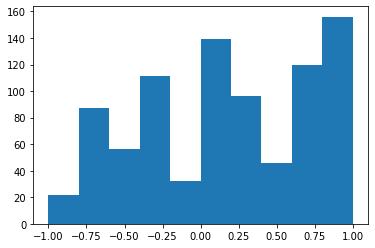

In [ ]:
plt.hist(spearman_coeffs)

In [32]:
test_dag

{0: {1, 2, 3, 4}, 1: {2, 4}, 3: {1, 2, 4}, 4: {2}}

In [67]:
test_dag = {0:{1}, 1:{2}, 2:{0}}

In [108]:
def dfs_rm_cycle(dag):
    for v in dag:
        discovered = [False] * 5
        s = []
        s.append(v)
        while s:
            v = s.pop()
            if not discovered[v]:
                discovered[v] = True
                if v in dag:
                    new_incidence = set()
                    for w in dag[v]:
                        if not discovered[w]:
                            new_incidence.add(w)
                            s.append(w)
                    dag[v] = new_incidence
        if np.array(discovered).all():
            return dag    